In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Importing all the key libraries
import os
# os.environ['WANDB_API_KEY'] = 'abc3e61cc8dfd07d2ba9a8661065c6de5303174d'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
from PIL import Image
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import wandb
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from torchvision.transforms import ToTensor

In [ ]:
# !wandb login

## Utility code

In [ ]:
class CustomImageDataset(torch.utils.data.Dataset):
    """ Custom Image dataset which overrides torch dataset class. Initialises
    the dataset and enables us to code the logic of retrieving images and labels from
    the directory structure we have
    """
    def __init__(self, dir, limit=None, indices=None, transform=None):
        self.data_dir = dir
        self.limit = int(1e10) if limit is None else limit
        self.images = []
        self.labels = []
        self.label_names = []
        i = 0
        for c in os.listdir(dir):
          ims = os.listdir(os.path.join(dir,c))[:self.limit]
          ims = [os.path.join(dir,c,im) for im in ims]
          self.images.extend(ims)
          self.labels.extend([i]*len(ims))
          self.label_names.append(c)
          i += 1

        if indices is not None:
            self.images = [self.images[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
        self.transform = transform

    # Defining the length of the dataset
    def __len__(self):
        return len(self.images)

    # Defining the method to get an item from the dataset
    def __getitem__(self, index):
        image = Image.open(self.images[index])
        image = image.convert("RGB")
        label = self.labels[index]
        # Applying the transform
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:

class CNN(nn.Module):
    """ Custom CNN object built on top of torch.nn.module. Gives us more control on our network
        w.r.t the architecture and hyperparameters. We also create our fully connected layer, by
        doing a dummy pass to our already created conv_block. We also don't use padding = "same"
        here, although that would have made it easier for us to
    """
    def __init__(self, input_size, depth, filter_size, pool_size, fc_size, num_classes,
                 activation_fn=nn.ReLU, use_batchnorm=True, dropout_p=0.5, filter_factor=1):
        super().__init__()
        in_c = 3
        out_c = depth

        self.conv_blocks = nn.Sequential()
        for i in range(5):
            layers = [nn.Conv2d(in_c, out_c, filter_size)]
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(activation_fn())
            layers.append(nn.MaxPool2d(kernel_size=pool_size))
            self.conv_blocks.add_module(f"conv_block_{i}", nn.Sequential(*layers))
            in_c = out_c
            if i%2 == 0:
              depth = int(depth*filter_factor)
              out_c = depth

        # Infer flattened feature size after conv layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, *input_size)
            out = self.conv_blocks(dummy_input)
            flatten_size = out.view(1, -1).shape[1]

        self.fc_layers = nn.Sequential(
            nn.Linear(flatten_size, fc_size),
            activation_fn(),
            nn.Dropout(p=dropout_p),  # Dropout between FC layers
            nn.Linear(fc_size, num_classes)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.fc_layers(x)
        return x


In [ ]:
def split_validation(label_array, valid_size = 0.1, seed = 42):
  """The functions splits the data into train and validation stratifiedly
  """
  train_idx, test_idx = [],[]
  for i,ci in enumerate(np.unique(label_array)):
      indices = np.where(label_array==ci)[0]
      train_len = int(indices.shape[0]*(1-valid_size))
      shuffled = np.random.RandomState(seed+i).permutation(indices)
      train_idx.extend(shuffled[:train_len])
      test_idx.extend(shuffled[train_len:])
  return train_idx,test_idx

In [ ]:
activation_map = {
    'ReLU': nn.ReLU,
    'GELU': nn.GELU,
    'SiLU': nn.SiLU,
    'Mish': nn.Mish
}

def set_seed(seed=42):
    """Sets random seeds for reproducibility.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.cuda.manual_seed_all(seed)

In [ ]:
class Trainer:
  """ Trainer agent which handles the training
  """
  def __init__(self):
    """ Initializing agent parameters
    """
    self.input_size = (224,224)
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = None
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model = None
    self.train_loader = None
    self.val_loader = None
    self.test_ds = None
    self.test_loader = None

  def create_model(self, depth,filter_size, pool_size, fc_size,
    activation_fn, filter_factor, use_batchnorm, dropout_p):
    """Creates our CNN model with the given set of hyper-parameters"
    """
    num_classes = 10
    model = CNN(input_size=self.input_size, depth=depth,
          filter_size=filter_size, pool_size=pool_size,
          fc_size=fc_size, num_classes=num_classes,
          activation_fn=activation_fn, dropout_p=dropout_p,
          use_batchnorm=use_batchnorm, filter_factor=filter_factor).to(self.device)
    self.model = model
    self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

  def create_data(self, batch_size, data_aug=False, limit=None, train=False):
      """ Creates train, val, test datasets with augmentation transforms if required.
      The limit controls how much of the dataset that we want to choose
      """
      TRAIN_DATA_PATH = "/kaggle/input/inaturalist/inaturalist_12K/train"
      TEST_DATA_PATH = "/kaggle/input/inaturalist/inaturalist_12K/val"

      base_transform = transforms.Compose([
                transforms.Resize(self.input_size),
                transforms.ToTensor()
              ])
      if data_aug:
          aug_transform = transforms.Compose([
                transforms.Resize(self.input_size),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.RandomRotation(degrees=10),
                transforms.ToTensor()
              ])
      else:
          aug_transform = base_transform

      # we apply data augmentation only to the train dataset
      if train:
        full_dataset = CustomImageDataset(
            TRAIN_DATA_PATH, limit=limit, transform=None)
        train_idx, val_idx = split_validation(
            full_dataset.labels, valid_size=0.2, seed=42)
        train_dataset = CustomImageDataset(
            TRAIN_DATA_PATH, limit=limit, transform=aug_transform, indices=train_idx)
        val_dataset = CustomImageDataset(
            TRAIN_DATA_PATH, limit=limit, transform=base_transform, indices=val_idx)
        self.train_loader = DataLoader(
            dataset=train_dataset, batch_size=batch_size,
            shuffle=True, num_workers=2)
        self.val_loader = DataLoader(
            dataset=val_dataset, batch_size=batch_size,
            num_workers=2)
      else:
        self.test_ds = CustomImageDataset(
            TEST_DATA_PATH, limit=limit, transform=base_transform)
        self.test_loader = DataLoader(
          num_workers=2,dataset=self.test_ds, batch_size=batch_size)

  def worker_init_fn(self, worker_id):
        """ Set worker seed for reproducibility
        """
        np.random.seed(torch.initial_seed() % 2**32)

  def run_step(self, dataloader, is_train=False):
      """ Runs one step of optimization if needed and evaluates the model
      """
      correct = 0
      total = 0
      cum_loss = 0
      if is_train:
        self.model.train()
      else:
        self.model.eval()

      for batch_index, (data, targets) in enumerate(tqdm(dataloader)):
          data = data.to(self.device)
          targets = targets.to(self.device)

          with torch.set_grad_enabled(is_train):
            outputs = self.model(data)
            loss = self.criterion(outputs, targets)
            cum_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (preds == targets).sum().item()
            if is_train:
              self.optimizer.zero_grad()
              loss.backward()
              self.optimizer.step()
      acc = correct/total
      return cum_loss, acc

  def run_train_pipeline(self, n_epochs, limit=None, use_wandb=False, config=None):
      """ Pipeline setup for the whole training process, includes data creation, model
      creation, integration with wandb and model evaluation
      """
      if use_wandb:
        run = wandb.run
      else:
        run = None

      set_seed(42)
      batch_size = config.batch_size
      depth = config.depth
      filter_size = config.filter_size
      pool_size = config.pool_size
      fc_size = config.fc_size
      activation_fn = config.activation_fn
      filter_factor = config.filter_factor
      use_batchnorm = config.use_batchnorm
      dropout_p = config.dropout_p
      data_aug = config.data_aug

      if run:
        run.name = f"bs:{batch_size}, d:{depth}, fs:{filter_size},\
        ps:{pool_size}, fc:{fc_size}, af:{activation_fn},\
        ff:{filter_factor}, bn:{use_batchnorm}, dp:{dropout_p},\
        da:{data_aug}"

      self.create_model(
          depth, filter_size, pool_size, fc_size,\
          activation_map[activation_fn], filter_factor, \
          use_batchnorm, dropout_p
      )
      self.create_data(batch_size, data_aug=data_aug, limit=limit, train=True)

      for epoch in range(n_epochs):
        train_loss, train_acc = self.run_step(self.train_loader, is_train=True)
        val_loss, val_acc = self.run_step(self.val_loader)
        if run:
          wandb.log({
              'epoch':epoch,
              'train_loss':train_loss, 'train_acc':train_acc,
              'val_loss':val_loss, 'val_acc':val_acc
          })
        else:
          print({
              'epoch':epoch,
              'train_loss':train_loss, 'train_acc':train_acc,
              'val_loss':val_loss, 'val_acc':val_acc
          })

  def test(self):
      """ Function to run inference on test set
      """
      batch_size = 128
      self.create_data(batch_size)
      self.model.eval()
      test_loss,test_acc = self.run_step(self.test_loader)
      print(f"Loss on test set : {test_loss}")
      print(f"Accuracy on test set : {test_acc}")

  def visualize_predictions(self):
      """ Function to visualize our model predictions
      """
      TEST_DATA_PATH = "/kaggle/input/inaturalist/inaturalist_12K/val"
      base_transform = transforms.Compose([
              transforms.Resize(self.input_size),
              transforms.ToTensor()
            ])
      label_array = self.test_ds.labels
      label_map = self.test_ds.label_names
      all_indices = []
      all_labels = []
      for i,ci in enumerate(np.unique(label_array)):
          indices = np.where(label_array==ci)[0]
          all_indices.extend(random.sample(indices.tolist(),3))
          all_labels.extend([ci]*3)


      view_dataset = CustomImageDataset(
            TEST_DATA_PATH, limit=None, transform=base_transform, indices=all_indices)

      figure = plt.figure(figsize=(16, 16))
      cols, rows = 3, 10
      for i in range(1, cols * rows + 1):
          img, label = view_dataset[i-1]
          with torch.no_grad():
            pred = self.model(img.unsqueeze(0).to(self.device))
          pred_label = label_map[torch.argmax(pred).item()]
          figure.add_subplot(rows, cols, i)
          plt.title(f"Actual:{label_map[label]}, Pred:{pred_label}")
          plt.axis("off")
          img_vis = img.permute(1, 2, 0).cpu().numpy()
          plt.imshow(img_vis)
      plt.tight_layout()
      plt.show()



## Best model - Train, Evaluation and Visualization

In [ ]:
from types import SimpleNamespace
batch_size = 64
depth = 64
filter_size = 4
pool_size = 2
fc_size = 240
activation_fn = 'Mish'
use_batchnorm = True
dropout_p = 0
filter_factor = 1
data_aug = True

config = SimpleNamespace(
   batch_size=batch_size,
   depth=depth,
   filter_size=filter_size,
   pool_size=pool_size,
   fc_size=fc_size,
   activation_fn = activation_fn,
   use_batchnorm = use_batchnorm,
   dropout_p = dropout_p,
   filter_factor = filter_factor,
   data_aug = data_aug
)
n_epochs = 13

In [ ]:
tr = Trainer()
tr.run_train_pipeline(n_epochs=n_epochs, limit=None, use_wandb=False, config=config)

100%|██████████| 32/32 [00:12<00:00,  2.53it/s]


{'epoch': 0, 'train_loss': 265.80016791820526, 'train_acc': 0.22152769096137018, 'val_loss': 73.4842175245285, 'val_acc': 0.1805}


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


{'epoch': 1, 'train_loss': 250.68664157390594, 'train_acc': 0.27728466058257284, 'val_loss': 63.57706880569458, 'val_acc': 0.3025}


100%|██████████| 32/32 [00:12<00:00,  2.65it/s]


{'epoch': 2, 'train_loss': 241.311439037323, 'train_acc': 0.3189148643580448, 'val_loss': 63.962982177734375, 'val_acc': 0.305}


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


{'epoch': 3, 'train_loss': 234.8672707080841, 'train_acc': 0.3414176772096512, 'val_loss': 64.85029625892639, 'val_acc': 0.2935}


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


{'epoch': 4, 'train_loss': 227.96493077278137, 'train_acc': 0.3527940992624078, 'val_loss': 60.333314538002014, 'val_acc': 0.343}


100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


{'epoch': 5, 'train_loss': 221.55912864208221, 'train_acc': 0.37654706838354796, 'val_loss': 60.50242567062378, 'val_acc': 0.344}


100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


{'epoch': 6, 'train_loss': 216.08358001708984, 'train_acc': 0.3929241155144393, 'val_loss': 59.67900347709656, 'val_acc': 0.36}


100%|██████████| 32/32 [00:11<00:00,  2.81it/s]


{'epoch': 7, 'train_loss': 209.7430453300476, 'train_acc': 0.4060507563445431, 'val_loss': 59.01727515459061, 'val_acc': 0.3635}


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


{'epoch': 8, 'train_loss': 204.02703869342804, 'train_acc': 0.4289286160770096, 'val_loss': 59.501020193099976, 'val_acc': 0.3725}


100%|██████████| 32/32 [00:11<00:00,  2.71it/s]


{'epoch': 9, 'train_loss': 197.70612132549286, 'train_acc': 0.4424303037879735, 'val_loss': 59.14709758758545, 'val_acc': 0.3705}


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]


{'epoch': 10, 'train_loss': 190.322438955307, 'train_acc': 0.4651831478934867, 'val_loss': 57.561460733413696, 'val_acc': 0.3895}


100%|██████████| 32/32 [00:11<00:00,  2.82it/s]


{'epoch': 11, 'train_loss': 183.35564839839935, 'train_acc': 0.4853106638329791, 'val_loss': 62.61214601993561, 'val_acc': 0.3435}


100%|██████████| 32/32 [00:11<00:00,  2.68it/s]

{'epoch': 12, 'train_loss': 178.49548935890198, 'train_acc': 0.49743717964745593, 'val_loss': 58.24529981613159, 'val_acc': 0.3675}


In [ ]:
tr.test()

100%|██████████| 16/16 [00:13<00:00,  1.17it/s]

Loss on test set : 28.469341039657593
Accuracy on test set : 0.4115


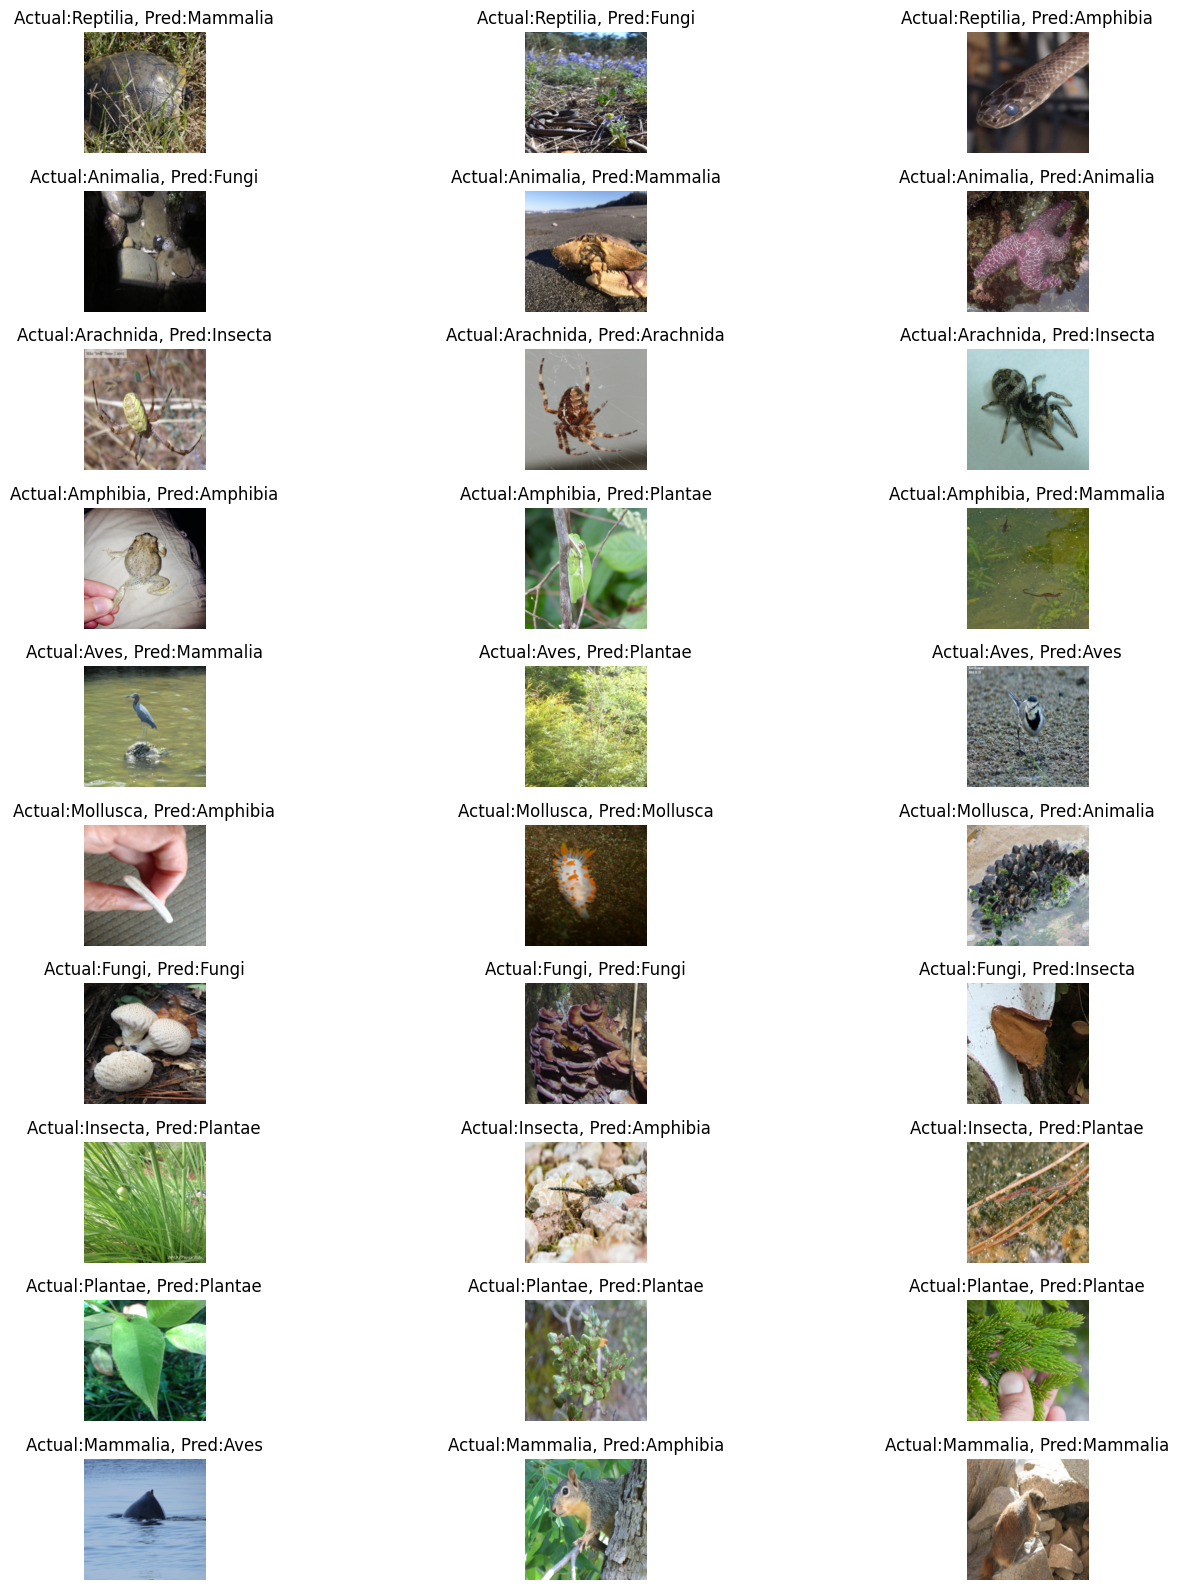

In [ ]:
tr.visualize_predictions()

## Hyperparameter sweep

In [ ]:
sweep_config = {
    'method': 'bayes'
    }


In [ ]:
project = 'DA6401_A2'
entity = 'jayagowtham-indian-institute-of-technology-madras'

In [ ]:
metric = {
    'name': 'val_acc',
    'goal': 'maximize'
    }

sweep_config['metric'] = metric

In [ ]:
sweep_config['name'] = 'third_finest_sweep'

In [ ]:
parameters_dict = {
    'batch_size': {
        'values': [64, 128]
        },
    'depth': {
        'values': [64]
        },
    'filter_size': {
          'values': [4]
        },
    'pool_size': {
          'values': [2]
        },
    'fc_size': {
          'values': [240]
        },
    'activation_fn': {
          'values': ['SiLU', 'Mish']
        },
    'dropout_p': {
          'values': [0, 0.3, 0.5]
        },
    'filter_factor': {
          'values': [0.5, 1, 2]
        },
    'use_batchnorm': {
          'values': [False, True]
        },
    'data_aug': {
          'values': [False, True]
        }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(project=project, entity=entity, sweep=sweep_config)

Create sweep with ID: ovvbr47c
Sweep URL: https://wandb.ai/jayagowtham-indian-institute-of-technology-madras/DA6401_A2/sweeps/ovvbr47c


In [ ]:
import gc

n_epochs = 10
def sweep_train():
    run = wandb.init()
    config = wandb.config
    tr = Trainer()
    tr.run_train_pipeline(n_epochs=n_epochs, limit=None, use_wandb=True, config=config)

    del tr.model
    del tr.train_loader
    del tr.val_loader
    del tr
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
wandb.agent('ovvbr47c', sweep_train, entity=entity, project=project, count=10)

wandb: Agent Starting Run: 8yuerr2e with config:
wandb: 	activation_fn: SiLU
wandb: 	batch_size: 128
wandb: 	data_aug: True
wandb: 	depth: 64
wandb: 	dropout_p: 0.5
wandb: 	fc_size: 240
wandb: 	filter_factor: 1
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: True
wandb: Currently logged in as: jayagowtham (jayagowtham-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_acc,▁▄▅▇▆▄█▇▄▇
val_loss,█▆▃▂▂▅▂▁▄▂
epoch,9
train_acc,0.41105
train_loss,106.01253
val_acc,0.353
val_loss,29.46587


wandb: Agent Starting Run: 6tlaz0ih with config:
wandb: 	activation_fn: Mish
wandb: 	batch_size: 128
wandb: 	data_aug: False
wandb: 	depth: 64
wandb: 	dropout_p: 0.3
wandb: 	fc_size: 240
wandb: 	filter_factor: 2
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: True


100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_acc,▁▃▄▆▇█▅▅██
val_loss,█▅▇▃▂▂▃▅▂▁
epoch,9
train_acc,0.40605
train_loss,104.86454
val_acc,0.328
val_loss,30.06128


wandb: Agent Starting Run: 0fsn9jnh with config:
wandb: 	activation_fn: Mish
wandb: 	batch_size: 128
wandb: 	data_aug: False
wandb: 	depth: 64
wandb: 	dropout_p: 0.5
wandb: 	fc_size: 240
wandb: 	filter_factor: 0.5
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: True


100%|██████████| 16/16 [00:11<00:00,  1.33it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_acc,▁▄▃▅▅▅▃▂█▄
val_loss,▆▄▄▃▃▂██▁▇
epoch,9
train_acc,0.43655
train_loss,101.59856
val_acc,0.3125
val_loss,33.74392


wandb: Agent Starting Run: 23xfoyxd with config:
wandb: 	activation_fn: SiLU
wandb: 	batch_size: 128
wandb: 	data_aug: True
wandb: 	depth: 64
wandb: 	dropout_p: 0
wandb: 	fc_size: 240
wandb: 	filter_factor: 1
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: True


100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_acc,▁▅▄█▆▆▆▇█▄
val_loss,█▅▄▁▂▃▃▁▁▅
epoch,9
train_acc,0.45643
train_loss,98.33699
val_acc,0.306
val_loss,31.12908


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k4k3smuz with config:
wandb: 	activation_fn: SiLU
wandb: 	batch_size: 64
wandb: 	data_aug: True
wandb: 	depth: 64
wandb: 	dropout_p: 0.5
wandb: 	fc_size: 240
wandb: 	filter_factor: 0.5
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: True


100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▅▆▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▄▆▅▆▇▅██▆
val_loss,█▅▄▅▃▂▅▁▁▄
epoch,9
train_acc,0.38305
train_loss,220.50025
val_acc,0.324
val_loss,61.48531


wandb: Agent Starting Run: 78f1isq1 with config:
wandb: 	activation_fn: Mish
wandb: 	batch_size: 64
wandb: 	data_aug: False
wandb: 	depth: 64
wandb: 	dropout_p: 0
wandb: 	fc_size: 240
wandb: 	filter_factor: 0.5
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: True


100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▄▅▅▆▇▇█
train_loss,█▇▆▅▅▄▃▃▂▁
val_acc,▁▅▅▇▇▇█▃▇▇
val_loss,▅▂▄▁▂▂▁█▂▄
epoch,9
train_acc,0.51306
train_loss,173.04014
val_acc,0.343
val_loss,64.38687


wandb: Agent Starting Run: i8s5eujn with config:
wandb: 	activation_fn: Mish
wandb: 	batch_size: 128
wandb: 	data_aug: True
wandb: 	depth: 64
wandb: 	dropout_p: 0.3
wandb: 	fc_size: 240
wandb: 	filter_factor: 1
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: False


100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇▇█
train_loss,█▇▅▄▄▃▃▂▂▁
val_acc,▁▄▄▆▆▇▇▇▇█
val_loss,█▆▅▄▃▂▂▂▂▁
epoch,9
train_acc,0.3808
train_loss,111.26276
val_acc,0.3665
val_loss,29.22947


wandb: Agent Starting Run: trwwvcyj with config:
wandb: 	activation_fn: Mish
wandb: 	batch_size: 128
wandb: 	data_aug: False
wandb: 	depth: 64
wandb: 	dropout_p: 0.5
wandb: 	fc_size: 240
wandb: 	filter_factor: 1
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: False


100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▄▅▅▆▇▇█
train_loss,█▆▆▅▄▄▃▃▂▁
val_acc,▁▄▅█▇█████
val_loss,█▆▄▂▂▂▁▁▁▁
epoch,9
train_acc,0.4338
train_loss,101.78023
val_acc,0.342
val_loss,30.43751


wandb: Agent Starting Run: 2wz328w2 with config:
wandb: 	activation_fn: SiLU
wandb: 	batch_size: 128
wandb: 	data_aug: False
wandb: 	depth: 64
wandb: 	dropout_p: 0.3
wandb: 	fc_size: 240
wandb: 	filter_factor: 2
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: True


100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▄▅▅▆▇▇█
train_loss,█▆▆▅▄▄▃▂▂▁
val_acc,▁▄▅▂▅▆▇▇█▄
val_loss,█▄▃▆▂▂▂▃▁█
epoch,9
train_acc,0.44606
train_loss,99.15066
val_acc,0.281
val_loss,35.12139


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ix1dvktm with config:
wandb: 	activation_fn: SiLU
wandb: 	batch_size: 128
wandb: 	data_aug: True
wandb: 	depth: 64
wandb: 	dropout_p: 0
wandb: 	fc_size: 240
wandb: 	filter_factor: 0.5
wandb: 	filter_size: 4
wandb: 	pool_size: 2
wandb: 	use_batchnorm: False


100%|██████████| 16/16 [00:11<00:00,  1.35it/s]


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇▇█
train_loss,█▇▅▄▄▃▃▂▂▁
val_acc,▁▁▄▄▅▆▇▇▇█
val_loss,█▇▅▄▃▃▂▂▂▁
epoch,9
train_acc,0.34579
train_loss,116.24679
val_acc,0.3455
val_loss,30.30358


In [3]:
!git status

Refresh index: 100% (4/4), done.
On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Assignment_2A.ipynb
	modified:   Assignment_2B.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	wandb/

no changes added to commit (use "git add" and/or "git commit -a")


In [1]:
!git add -u .

fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git commit -m "Bug fixes"

[main 451b6a1] Bug fixes
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Assignment_2.ipynb (87%)


In [ ]:
!git push origin

Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.40 KiB | 130.00 KiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/JG-0212/DA6401_A2.git
   87c94b3..451b6a1  main -> main
